<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Feature Engineering

In [184]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [185]:
# Load mammals data set
mammals_path = '../assets/data/mammals.txt'
cols = ['brain', 'body']
mammals = pd.read_csv(mammals_path, sep='\t', names=cols, header=0)

In [186]:
mammals.head()

,brain,body
0,3.385,44.5
1,0.480,15.5
2,1.350,8.1
3,465.000,423.0
4,36.330,119.5


In [187]:
# Remove extreme values and sort by body for easier plotting
\
mammals = mammals.loc[mammals.loc[:, 'body'] <= 200, :].sort_values('body')
mammals.head()

,brain,body
13,0.005,0.14
39,0.010,0.25
19,0.023,0.30
54,0.048,0.33
38,0.023,0.40


## Demo

Brain size and body size are clearly related, but the relationship doesn't look particularly nice:

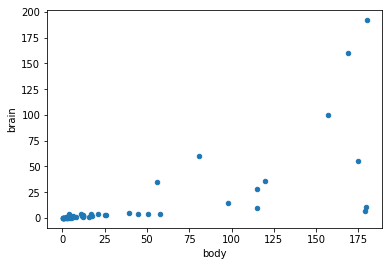

In [188]:
# Plot scatterplot of brain size against body size
ax = mammals.plot(kind='scatter', x='body', y='brain')

Let's see how it looks after we take the logarithm of both variables.

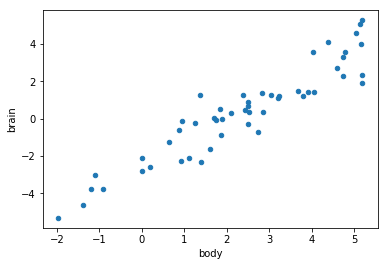

In [189]:
# Plot scatterplot of brain size against body size after log transformation
log_mammals = np.log(mammals)
ax = log_mammals.plot(kind='scatter',x='body',y='brain')

😍now it looks like a textbook example for linear regression.

This example illustrates the power of "feature engineering" -- transforming your variables to get better performance out of a machine learning model.

## Simple Linear Regression on the Mammals Dataset

In [190]:
# Check number of rows and columns in `mammals`
mammals.shape

(51, 2)

Let's try out a simple linear regression model: $\mbox{brain} = \beta_0 + \beta_1 * \mbox{body} + \epsilon$.

**Notes:**

- The mammals dataset has only 51 rows, so test-set metrics will be fairly unreliable in a simple train/test split. **We should use cross-validation**.
- MAE and MSE are arguably inappropriate for this dataset because they give the same score for an error of 500g (about 1 pound), for instance, regardless of whether we are predicting the brain size of a mouse or of an elephant, whereas it seems that being off by 500g is unacceptable if we are predicting mouse brain size but not bad if we are predicting elephant brain size. **A more appropriate metric is *mean absolute percentage error* (MAPE):** the average magnitude of the error in our prediction for `y` as a percent of `y`.

In [191]:
# Write a function to do leave-one-out cross-validation
# returning MAPE for both the training set and the test set
from sklearn.linear_model import LinearRegression


def my_cross_val_score(X, y):
    lr = LinearRegression()

    train_scores = []
    test_scores = []

    for rownum in X.index:
        X_train = X.drop(rownum)
        y_train = y.drop(rownum)
        X_test = X.loc[[rownum], :]
        y_test = y.loc[[rownum]]
        
        lr.fit(X_train, y_train)
        
        train_pred = lr.predict(X_train)
        percent_error_train = mape(y_train, train_pred)
        train_scores.append(percent_error_train)
        
        test_pred = lr.predict(X_test)
        percent_error_test = mape(y_test, test_pred)
        test_scores.append(percent_error_test)
    
    mape_train = np.array(train_scores).mean()
    mape_test = np.array(test_scores).mean()
    
    return mape_train, mape_test
        

def mape(y_true, y_pred):
    precent_errors = abs((y_true - y_pred) / y_true)
    mape = precent_errors.mean()
    return mape

In [192]:
# Create a linear regression model of brain weight against body weight,
# and calculate average RMSE on the training set and on the test set
# using leave-one-out cross-validation.
feature_cols = ['body']
target_col = 'brain'

X = mammals.loc[:, feature_cols]
y = mammals.loc[:, target_col]

my_cross_val_score(X, y)


(33.93398492390133, 35.02808298644269)

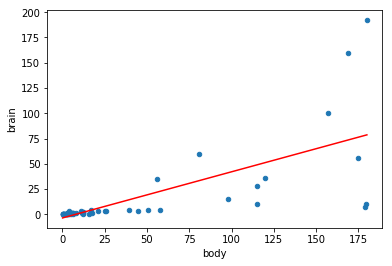

In [193]:
# Superimpose a line plot of the fitted values from a simple linear regression 
# model on a scatterplot of the individual data points.
ax = mammals.plot(kind='scatter', x='body', y='brain')

lr = LinearRegression()
lr.fit(X, y)
ax.plot(X, lr.predict(X), c='r')

## Polynomial Transformations

Linear regression creates a model that is linear in terms of features that you pass into it. **But linear regression can capture non-linear relationships with your original features if you give it non-linear transformations of those features.**

For instance, let's fit this model:

$\mbox{brain} = \beta_0 + \beta_1 * \mbox{body} + \beta_2 * \mbox{body}^2 + \epsilon$

In [194]:
# Create and evaluate a model as before, but with body**2 as an additional feature
mammals.loc[:, 'body_squared'] = mammals.loc[:, 'body']**2

feature_cols = ['body', 'body_squared']

X = mammals.loc[:, feature_cols]

my_cross_val_score(X, y)

(3.371053772857734, 2.6357962013405687)

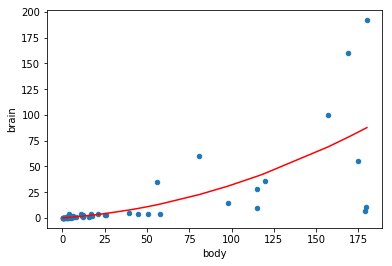

In [195]:
# Plot the resulting model on top of the corresponding scatterplot
ax = mammals.plot(kind='scatter', x='body', y='brain')

lr = LinearRegression()
lr.fit(X, y)
ax.plot(X.loc[:, 'body'], lr.predict(X), c='r');

In [196]:
# Clean up by dropped body_squared
mammals = mammals.drop('body_squared', axis='columns')

MSE has not improved much, but MAPE has improve dramatically because the model is able to do a better job for body sizes 0-25kg.

In general, A polynomial function of x has the form $c_0 + c_1x + c_2x^2 + c_3x^3 + \ldots$.

If you give a linear regression model $x$, $x^2$, and $x^3$ as features, for instance, it will find the $\beta_0$, $\beta_1$, $\beta_2$, and $\beta_3$ that minimizes mean-squared error for using $\beta_0 + \beta_1x + \beta_2x^2 + \beta_3x^3$ to predict $y$.

It can always recover simple linear regression by setting the coefficients on the higher-order terms to 0, so adding these higher-order terms only increases the set of relationships that the model can capture.

**Exercise (1 min.)**

- How does adding higher-order polynomial terms as inputs to a linear regression model affect its bias and variance?

Adding higher-order polynomimal terms as inputs can reduce bias but increase variance

$\blacksquare$

**Every additional polynomial term gives your model an additional chance to change directions.**

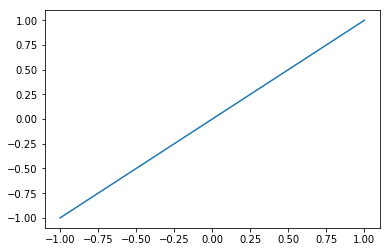

In [197]:
# first-order
x = np.linspace(-1, 1, 100)
plt.plot(x, x);

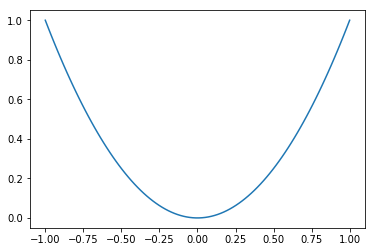

In [198]:
# second-order
plt.plot(x, x**2);

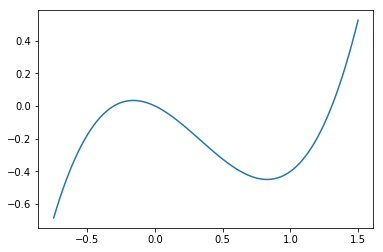

In [199]:
# third-order
x = np.linspace(-.75, 1.5, 100)
plt.plot(x, -.4*x - x**2 + x**3);

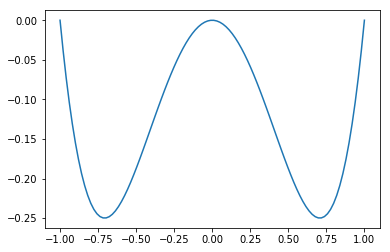

In [200]:
# fourth-order
x = np.linspace(-1, 1, 100)
plt.plot(x, -x**2 + x**4);

Too many polynomial terms leads to overfitting

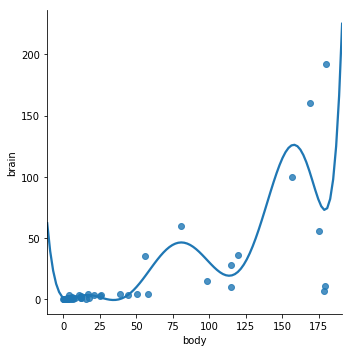

In [201]:
# 8th-order model
g = sns.lmplot(x='body', y='brain', data=mammals, ci=None, order=8);

An (n-1)-order polynomial can always fit n data points perfectly. It is definitely overfitting!

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\regression.py:237: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)


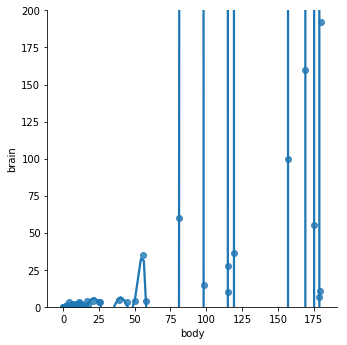

In [202]:
# 50th-order model
fig = sns.lmplot(x='body', y='brain', data=mammals, ci=None, order=50);
ax = fig.axes
ax[0,0].set_ylim(0, 200);

Including multiple transformations of one variable complicates coefficient interpretation.

In [203]:
# Print intercept and coefficients from second-order model we created earlier
#LinearRegression?
print(lr.intercept_)
print(lr.coef_)

0.13198730573592954
[0.10843153 0.00210168]


**Exercise (2 mins.)**

- Write down the equation of this second-order model (with fitted coefficient values).

$brain = 0.1319873 + 0.10843153(body) + 0.00210168(body**2)$

- How would you normally interpret the coefficient on `body` in a linear regression model of brain weight against body weight along with some other features? Why doesn't that interpretation work in this case?

The increase in brain size for a one unit increase in body size when all other variables are fixed.  This interpretation does not work in this case because the two model variables are both body size.  If body size changes, so does body size ^2.

$\blacksquare$

**sklearn has a "transformer" that generates polynomial terms**

In [204]:
# sklearn transformers have the same interface as "estimators" (models)
# except that you fit them on features and use them to transform features,
# rather than fitting them on features and a target and using them to predict
# the target.
from sklearn.preprocessing import PolynomialFeatures

X=mammals.loc[:,['body']]
pf=PolynomialFeatures(degree=3, include_bias=False)
X_poly = pf.fit_transform(X)
X_poly

array([[1.40000000e-01, 1.96000000e-02, 2.74400000e-03],
       [2.50000000e-01, 6.25000000e-02, 1.56250000e-02],
       [3.00000000e-01, 9.00000000e-02, 2.70000000e-02],
       [3.30000000e-01, 1.08900000e-01, 3.59370000e-02],
       [4.00000000e-01, 1.60000000e-01, 6.40000000e-02],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.20000000e+00, 1.44000000e+00, 1.72800000e+00],
       [1.90000000e+00, 3.61000000e+00, 6.85900000e+00],
       [2.40000000e+00, 5.76000000e+00, 1.38240000e+01],
       [2.50000000e+00, 6.25000000e+00, 1.56250000e+01],
       [2.60000000e+00, 6.76000000e+00, 1.75760000e+01],
       [3.00000000e+00, 9.00000000e+00, 2.70000000e+01],
       [3.50000000e+00, 1.22500000e+01, 4.28750000e+01],
       [3.90000000e+00, 1.52100000e+01, 5.93190000e+01],
       [4.00000000e+00, 1.60000000e+01, 6.40000000e+01],
       [5.00000000e+00, 2.50000000e+01, 1.25000000e+02],
       [5.50000000e+00, 3.02500

A transformer returns a modified copy of the object it acts on without changing that objects in place.

In [205]:
# Score a model that uses the polynomial features
X_poly_df = pd.DataFrame(X_poly, index = X.index)
my_cross_val_score(X_poly_df, y)

(7.910035317586043, 8.258039319785441)

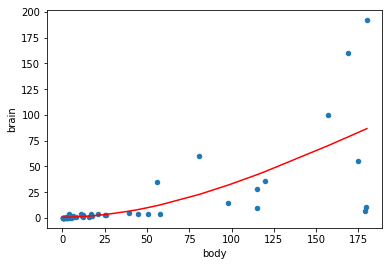

In [206]:
# Plot the resulting model on top of the corresponding scatterplot
ax = mammals.plot(kind='scatter', x='body', y='brain')

lr = LinearRegression()
lr.fit(X_poly_df, y)
ax.plot(X.loc[:, 'body'], lr.predict(X_poly), c='r');

The linear regression algorithm is still trying to minimize MSE, and in this case giving it more flexibility in minimizing MSE led to a higher MAPE.

**Exercise (10 mins., pair programming)**

Use the Boston housing data for the exercises below.

In [207]:
from sklearn.datasets import load_boston

boston = load_boston()
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = pd.DataFrame(boston.target, columns=['MEDV'])
boston = pd.concat([X, y], axis=1)
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


- Create a linear regression model for MEDV against DIS with no higher-order polynomial terms. Train it on a training set and measure its R2 on both the training set and a test set, using a simple train/test split.

*Tip*: Use a new variable such as `X1` to store your feature variable DataFrame for this exercise, rather than overwriting `X`.

In [208]:
from sklearn.model_selection import train_test_split
feature_cols = ['DIS']
X1 = boston.loc[:,feature_cols]
X_train,X_test,y_train, y_test = train_test_split(X1,y)
lr=LinearRegression()
lr.fit(X1,y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [209]:
lr.score(X_train, y_train)

0.06370968713226743

In [210]:
lr.score(X_test, y_test)

0.045203309303042505

- **BONUS** (come back to this exercise after completing the non-bonus exercises): Plot your model's fitted values as a function of DIS and overlay them on scatterplots of MEDV against DIS.

- Create a model as before, but use polynomial terms for DIS up to and including degree two.

*Tip*: Use a new variable such as `X2` to store your feature variable DataFrame for this exercise, rather than overwriting `X`.

In [211]:
pf = PolynomialFeatures(degree=2, include_bias=False)
X1_poly = pf.fit_transform(X1)
X1_poly = pd.DataFrame(X2_poly)
X1.loc[:,'DIS_squared'] = X1_poly.loc[:,1]

In [212]:
X2 =X1.loc[:,['DIS', 'DIS_squared']]
X_train,X_test,y_train, y_test = train_test_split(X2,y)
lr=LinearRegression()
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

- **BONUS** (come back to this exercise after completing the non-bonus exercises): Plot your model's fitted values as a function of DIS and overlay them on scatterplots of MEDV against DIS.

*Tip:* If the result looks like spaghetti, then you probably need to sort the data you are passinginto the model on DIS.

- Create a model as before, but use polynomial terms for DIS up to and including degree seven.

- **BONUS**: Plot your model's fitted values as a function of DIS and overlay them on scatterplots of MEDV against DIS.

*Tip*: Use a new variable such as `X2` to store your feature variable DataFrame for this exercise, rather than overwriting `X`.

- **BONUS:** Create a model as before, but use DIS^(-1) along with DIS as your features.

- **BONUS**: Plot your model's fitted values as a function of DIS and overlay them on scatterplots of MEDV against DIS.

*Tip*: Use a new variable such as `X2` to store your feature variable DataFrame for this exercise, rather than overwriting `X`.

$\blacksquare$

**Notes.**

- It is extremely unusual to use more than a third-order polynomial in statistics. It is more common in machine learning, where the emphasis tends to be on predictive accuracy rather than understanding.
- It would be unusual to use a polynomial term without including all lower-order polynomial terms.
- In addition to polynomial terms (with positive integer exponents), it can also be beneficial to include terms with negative exponents (e.g. $x^{-1}=1/x$) and/or fractional exponents (e.g. $x^{1/2}=\sqrt{X}$).
- The "bulging rule" tells you what transformations to consider based on which way the "bulge" goes in a scatterplot between a particular feature `x` and the target `y`. You can transform `x`, `y`, or both, but transforming `y` means that you have to do some extra work to make your metrics comparable before and after the transformation.

<img src="../assets/images/bulging_rule.png" style="height: 400px">

## Interaction Terms

Sometimes the significance of one feature depends on the value of another feature.

For instance, perhaps median housing prices increase as you get closer to a major employment center *unless crime is high around that area*.

We can model these kinds of "interaction effects" by including the *products* of the interacting variables as features in our models.

For example:

$$MEDV = \beta_0 + \beta_1 * DIS + \beta_2 * CRIM + \beta_{12} (DIS * CRIM)$$

In [213]:
# Implement the model above
feature_cols = ['DIS', 'CRIM']
X = boston.loc[:,feature_cols]
X.loc[:, 'INTER'] = X.loc[:,'DIS'] * X.loc[:,'CRIM']

X_train, X_test, y_train, y_test = train_test_split(X,y)

lr=LinearRegression()
lr.fit(X_train, y_train)
print(lr.score(X_train,y_train))
print(lr.score(X_test,y_test))

0.19053605096173598
0.18058172632568736


In [214]:
print(lr.intercept_)
print(lr.coef_)

[22.54579014]
[[ 0.43815923  0.43780163 -0.49266339]]


In [215]:
X.head()

,DIS,CRIM,INTER
0,4.0900,0.00632,0.025849
1,4.9671,0.02731,0.135652
2,4.9671,0.02729,0.135552
3,6.0622,0.03237,0.196233
4,6.0622,0.06905,0.418595


**Exercise (2 mins.)**

- Write down the fitted model we just created.

$y=21.733 + 0.321(DIS) + 0.4773(CRIM) +-.524(INTER)$

$\blacksquare$

In [216]:
# check descriptive stats
X.describe()

,DIS,CRIM,INTER
count,506.000000,506.000000,506.000000
mean,3.795043,3.613524,6.850345
std,2.105710,8.601545,13.921379
min,1.129600,0.006320,0.025849
25%,2.100175,0.082045,0.328496
50%,3.207450,0.256510,1.038928
75%,5.188425,3.677083,7.726243
max,12.126500,88.976200,132.552569


**Recall the usual interpretation of the coefficient on DIS:** how much the model's prediction for MEDV changes with a one-unit increase in DIS, all else being equal (i.e. for a particular value of CRIM).

**With interaction terms, interpreting the coefficients for a feature DIS requires specifying particular values for the interacting variables.**

For instance, if CRIM is fixed at its 25th percentile value of 0.082, we get

$MEDV = 22.62 + 0.48 * DIS + 0.467 * CRIM - 0.527 (DIS * CRIM)$

$MEDV = 22.62 + 0.48 * DIS + 0.467 * 0.082 - 0.527 (DIS * 0.082)$

$MEDV = 22.62 + 0.48 * DIS + 0.038 - 0.043 * DIS$

$MEDV = 22.658 + 0.437 * DIS$

So **at CRIM=.082**, the model's prediction for MEDV increases by .437 when DIS increases by one. It's better on average to be away from employment centers when crime is low.

The story is different when CRIM has its 75th percentile value of 3.64:

$MEDV = 22.62 + 0.48 * DIS + 0.467 * CRIM - 0.527 (DIS * CRIM)$

$MEDV = 22.62 + 0.48 * DIS + 0.467 * 3.64 - 0.527 (DIS * 3.64)$

$MEDV = 22.62 + 0.48 * DIS + 1.70 - 1.92 * DIS$

$MEDV = 24.32 -1.44 * DIS$

**At CRIM=3.64**, the model's prediction for MEDV *decreases* by 1.44 when DIS increases by one. It's better on average to be close to employment centers when crime is high.

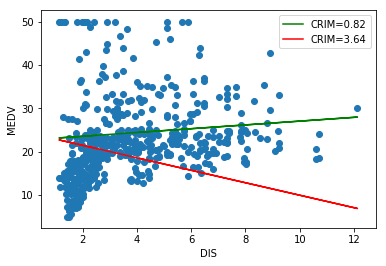

In [217]:
dis = X.loc[:, 'DIS']
y1 = 22.658 + 0.437*dis
y2 = 24.32 - 1.44*dis

fig, ax = plt.subplots()
ax.plot(dis, y1, c='g', label='CRIM=0.82')
ax.plot(dis, y2, c='r', label='CRIM=3.64')
ax.set_xlabel('DIS')
ax.set_ylabel('MEDV')
ax.scatter(X.loc[:, 'DIS'], y)
ax.legend();

**Exercise (8 mins., pair programming)**

- How does adding interaction terms affect a model's bias and variance?

For the exercises below you may use `sklearn.model_selection.cross_val_score`, but pass an `sklearn.model_selection.KFold` object with `shuffle=True` to the `cv` parameter rather than a number.

- Using 5-fold cross-validation, calculate R2 for a model predicting MEDV from DIS and CRIM without an interaction term. 

In [218]:
from sklearn.model_selection import cross_val_score, KFold

feature_cols = ['DIS', 'CRIM']
X = boston.loc[:, feature_cols]
y = boston.loc[:, 'MEDV']
lr = LinearRegression()
kf = KFold(n_splits=5, shuffle=True)

cross_val_score(lr, X, y, cv=kf).mean()

0.15113233023711653

- Using 5-fold cross-validation, calculate the MSE for a model predicting MEDV from DIS and CRIM with an interaction term. *Hint*: use sklearn.model_selection.cross_val_score

In [219]:
from sklearn.metrics import mean_squared_error
feature_cols = ['DIS', 'CRIM']
X = boston.loc[:, feature_cols]
X.loc[:, 'INTER'] = X.loc[:,'DIS'] * X.loc[:,'CRIM']
y = boston.loc[:, 'MEDV']
lr = LinearRegression()
kf = KFold(n_splits=5, shuffle=True)

cross_val_score(lr, X, y, cv=kf).mean()

X_train, X_test, y_train, y_test = train_test_split(X,y)

lr=LinearRegression()
lr.fit(X_train, y_train)
mean_squared_error(y_train, lr.predict(X_train))

61.119067704995096

- **Bonus:** Find the best model you can, as measured by MSE in 5-fold cross-validation.

In [220]:
mean_square_error?

Object `mean_square_error` not found.


$\blacksquare$

## Log Transformations

When your data is very skewed, try a log transformation.

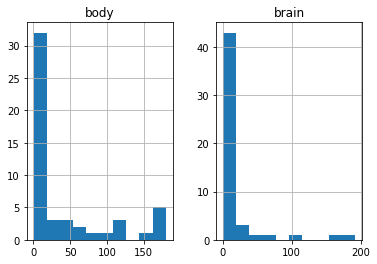

In [222]:
# Plot histograms of mammal brain and body sizes
axes = mammals.hist()

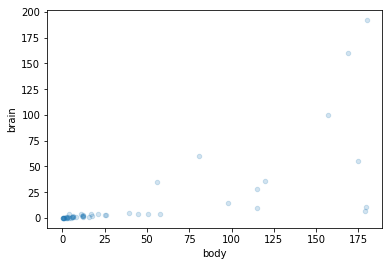

In [223]:
# Plot scatterplot of brain size against body size
axes =  mammals.plot(kind = 'scatter', x='body', y= 'brain', alpha = .2)

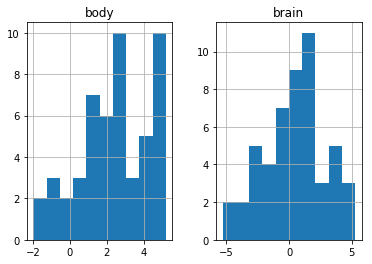

In [224]:
# Plot histograms of mammal brain and body sizes after a log transformation
log_mammals = np.log(mammals)
axes = log_mammals.hist()

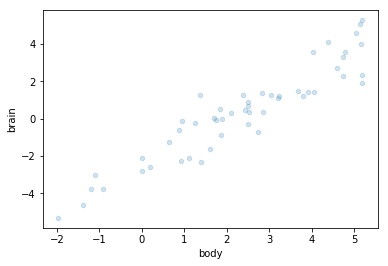

In [225]:
# Plot scatterplot of brain size against body size after log transformation
axes =  log_mammals.plot(kind = 'scatter', x='body', y= 'brain', alpha = .2)

The data looks much nicer after a log transformation -- the variables are highly correlated, and each looks approximately normal.

We need to be careful about how we measure performance so that we can do a fair before-and-after comparison -- MAPE of a model for $log(y)$, for instance, does not mean the same thing as MAPE of a model for $y$.

Perhaps the simplest way to make the comparison fair is to transform predictions for $log(y)$ back to predictions for $y$.

In [229]:
# Train and score a linear model in the log-transformed space.
feature_cols = ['body']
target_col = 'brain'

X = log_mammals.loc[:, feature_cols]
y = log_mammals.loc[:, target_col]

lr = LinearRegression()

train_scores = []
test_scores = []

for rownum in X.index:
    X_train = X.drop(rownum)
    y_train = y.drop(rownum)
    X_test = X.loc[[rownum], :]
    y_test = y.loc[[rownum]]

    lr.fit(X_train, y_train)

    train_pred = lr.predict(X_train)
    percent_error_train = mape(np.exp(y_train), np.exp(train_pred))
    train_scores.append(percent_error_train)

    test_pred = lr.predict(X_test)
    percent_error_test = mape(np.exp(y_test), np.exp(test_pred))
    test_scores.append(percent_error_test)

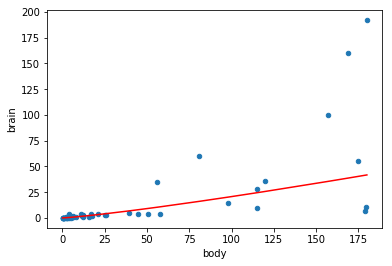

In [230]:
# Plot the model's predictions
np.array(train_scores).mean(), np.array(test_scores).mean()
lr.fit(X, y)

ax = mammals.plot(kind='scatter', x='body', y='brain')
ax.plot(mammals.loc[:, 'body'], np.exp(lr.predict(X)), c='r');

**Takeaways:**

- When your data is highly skewed, try a log transformation.
- When you evaluate a model that transforms $y$, make sure that you calculate metrics for different models on the same scale.

**Notes:**

- A log-transformed variable typically replaces the original variable in a regression analysis, unlike a polynomial term.
- You can apply a log transformation to any combination of your features and your target variable.

## Summary

- Linear regression *can* capture non-linear relationships *when you provide the appropriate non-linear transformations*.
- Every polynomial term you add allows your model to change directions once.
- Interaction terms allow for the possibility that the relationship between a given feature and the target depeneds on the value of another feature.
- Log transformations are appropriate for variables with highly skewed distributions.